# ICESat-2 Applications: SlideRule

Instructors: [Tyler Sutterley](mailto:tsutterl@uw.edu) and [Ian Joughin](mailto:ian@apl.washington.edu)

# Working with GRiMP Image Products
## Using nisarImage and nisarImageSeries Classes
---

The Greenland Ice Mapping Project (GrIMP aka GIMP) generates 6 or 12 day Sentinel-1 image mosaics for the Greenland coastline, extending back through 2015, which are archived at NSDIC under [NSIDC-0723](https://nsidc.org/data/nsidc-0723).

Collectively these products take up more than 2TB, which is more than most users may want to store locally, especially when interested in only a handful of glaciers. 

This notebook reviews how to work with subsets of these products downloaded directly from the NSIDC server using the `nisarImageSeries` class in the [nisardev](https://github.com/fastice/nisardev) package. We also take advantage of search tools in the [grimpfunc](https://github.com/fastice/grimpfunc) package.

Many of the concepts introduced in the early data integration tutorial (e.g., image stacks, xarray, pandas) are used here, though they are often incorporated into class definitions. For those who are curious, the code can be viewed [here](https://github.com/fastice/nisardev/tree/main/nisardev).

## Python Setup

The following packages are needed to execute this notebook. 

In [ ]:
! pip install git+https://github.com/ICESat2-SlideRule/sliderule-python.git
! pip install nisardev
! pip install grimpfunc

In [17]:
import os
import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
import panel as pn
pn.extension()
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import shapely.geometry
import warnings
# grimp and nisar functions
import grimpfunc as grimp
import nisardev as nisar
# sliderule functions
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule

# autoreload
%load_ext autoreload
%autoreload 2
# register progress bar and set workers
ProgressBar().register()
dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Login to EarthData/NSIDC

Unless the data have already been downloaded, users will need to sign in to NSIDC/EarthData to run the rest of the notebook. If a ~/.netrc exists, it will load credentials from there. If not, it will create or append to one after the login has been processed since it is needed by GDAL (see [NSIDCLoginNotebook](https://github.com/fastice/GRiMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb)) for more details on security issues.

In [21]:
# Set path for gdal 
#!rm ~/.netrc
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
# Get login
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


## Bounding Box

The examples in this glacier will focus on Zacharie Isstrom in northern Greenland, which can be defined with the following bounding box.

In [22]:
bbox = {'minx': 440000, 'miny': -1140000, 'maxx': 525000, 'maxy': -1080000}
xbox = np.array([bbox[x] for x in ['minx', 'minx', 'maxx', 'maxx', 'minx']]) * 0.001
ybox = np.array([bbox[y] for y in ['miny', 'maxy', 'maxy', 'miny', 'miny']]) * 0.001

## Search for Data

Greenland Mapping Project data can be searched for using instances of the class, `cmrUrls`, which provides a simple graphical and non-graphical interface to the GMP products. 

In this example, the search tool is used with `mode='image'`, which restricts the search to **NSIDC-0723** image products. 

The date range can restricted with `firstDate='YYYY-MM-DD'` and `lastDate='YYYY-MM-DD'`. 

The images are distributed as uncalibrated **image** products or calibrated **sigma0** ($\sigma_o$) and **gamma0** ($\gamma_o$) products.

In the next cell, we select the **image** products, which can be specified as `productFilter='image'`. 

In the following example, these search will be carried out based on the input parameters, but a gui search window will popup, which allows the search parameters to be altered.

### Image Data

In [23]:
myImageUrls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
myImageUrls.initialSearch(firstDate='2020-01-01', lastDate='2020-02-24', productFilter='image') 

Row
    [0] Column(min_width=300)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=300)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method)
        [1] ParamMethod(method)
        [2] ParamMethod(method)

If the search parameters do not need to be altered, then insering a semicolon at the end of the line will supress the output. So the corresponding sigma0 and gamma0 products can searched for as:

In [24]:
mySigma0Urls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
mySigma0Urls.initialSearch(firstDate='2020-01-01', lastDate='2020-02-24', productFilter='sigma0');
myGamma0Urls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
myGamma0Urls.initialSearch(firstDate='2020-01-01', lastDate='2020-02-24', productFilter='gamma0');

## Loading the data

Now that the data have been located, they can be opened for access. The list of urls is given by `myImageUrls.getCogs()` to be passed into the `readSeriesFromTiff` method.

In [25]:
myImageSeries = nisar.nisarImageSeries()  # Instantiate the series object
myImageSeries.readSeriesFromTiff(myImageUrls.getCogs())  # Open images with lazy reads
myImageSeries.subset  # Display map of data layout - add ; to suppress this output

<xarray.DataArray 'image' (time: 10, band: 1, y: 106440, x: 59040)>
dask.array<concatenate, shape=(10, 1, 106440, 59040), dtype=uint8, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'image'
  * x            (x) float64 -6.26e+05 -6.26e+05 -6.259e+05 ... 8.5e+05 8.5e+05
  * y            (y) float64 -6.95e+05 -6.95e+05 ... -3.356e+06 -3.356e+06
  * time         (time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-02-24T12:...
    name         <U4 'None'
    _FillValue   int64 0
    time1        (time) datetime64[ns] 2019-12-30 2020-01-05 ... 2020-02-22
    time2        (time) datetime64[ns] 2020-01-04 2020-01-10 ... 2020-02-27
    spatial_ref  int64 0

At nearly 60GB, and this is only 10 of 300+ products, downloading this full data set would take a substantial amount of time, even over a fast network. 

But if we use the bounding box defined above, the data set can be limited to just the region of interest as follows:

In [26]:
myImageSeries.subSetImage(bbox)
myImageSeries.subset

<xarray.DataArray 'ImageSeries' (time: 10, band: 1, y: 2400, x: 3400)>
dask.array<getitem, shape=(10, 1, 2400, 3400), dtype=uint8, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'image'
  * x            (x) float64 4.4e+05 4.4e+05 4.401e+05 ... 5.25e+05 5.25e+05
  * y            (y) float64 -1.08e+06 -1.08e+06 ... -1.14e+06 -1.14e+06
  * time         (time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-02-24T12:...
    name         <U4 'None'
    _FillValue   int64 0
    time1        (time) datetime64[ns] 2019-12-30 2020-01-05 ... 2020-02-22
    time2        (time) datetime64[ns] 2020-01-04 2020-01-10 ... 2020-02-27
    spatial_ref  int64 0

Here the volume as been greatly reduced. At this stage, the data are still on the NSIDC server. At this point several actions can be taken (e.g., displaying the data), which will automatically download the data using dask. While this implicit download is convenient, it can add time for multiple operations on the data. 

While in principle the data are cached by the OS, they can be flushed from the cache, require re-download. 

The volume in this example is not large for most computers, so it makes sense to explicitly download the data with as shown next:

In [27]:
myImageSeries.loadRemote()

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


The process can now be repeated with the sigma0 and gamma0 products.

In [28]:
myGamma0Series = nisar.nisarImageSeries()  # Instantiate the series object
myGamma0Series.readSeriesFromTiff(myGamma0Urls.getCogs())  # Open images with lazy reads
myGamma0Series.subSetImage(bbox)  # Clip image area
myGamma0Series.loadRemote()  # Download clipped regions

[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s


In [29]:
mySigma0Series = nisar.nisarImageSeries()  # Instantiate the series object
mySigma0Series.readSeriesFromTiff(mySigma0Urls.getCogs())  # Open images with lazy reads
mySigma0Series.subSetImage(bbox)  # Clip image area
mySigma0Series.loadRemote()  # Download clipped regions

[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.4s


## Overview Images

The code above download a small subset, but in some cases its nice to have an overview of the full data set. 

As noted above, a nice feature of COGs is that they include image pyramids. 

A reduced resolution data set can be created as:

In [30]:
myOverviewSeries = nisar.nisarImageSeries()  # Instantiate the series object
myOverviewSeries.readSeriesFromTiff(myImageUrls.getCogs()[0:2],  overviewLevel=4)  # Open image 4->800 m res (2^(n+1) * original res) = 32*.25
myOverviewSeries.loadRemote()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s


## Image Types

As noted above, the GMP Sentinel image mosaics are produced as:
- **image** (byte scaled with colortable stretch to enhance contrast), 
- **sigm0** (calibrated radar cross section),
- **gamma0** (calibrated cross section that reduces topographic effects). 

A more detailed description of the characteristics of these products is beyond the scope of this notebooks but can be found in the [user guide for NSIDC-0723](https://nsidc.org/data/nsidc-0723/). 

In the next cell, we take advantage of the `nisarImageSeries.displayImageForDate()` method, which will display the image from the stack that lies closest to the specified date.

The following cell illustrates how each of these products can be displayed for a given date with the overview image used as an inset map. 

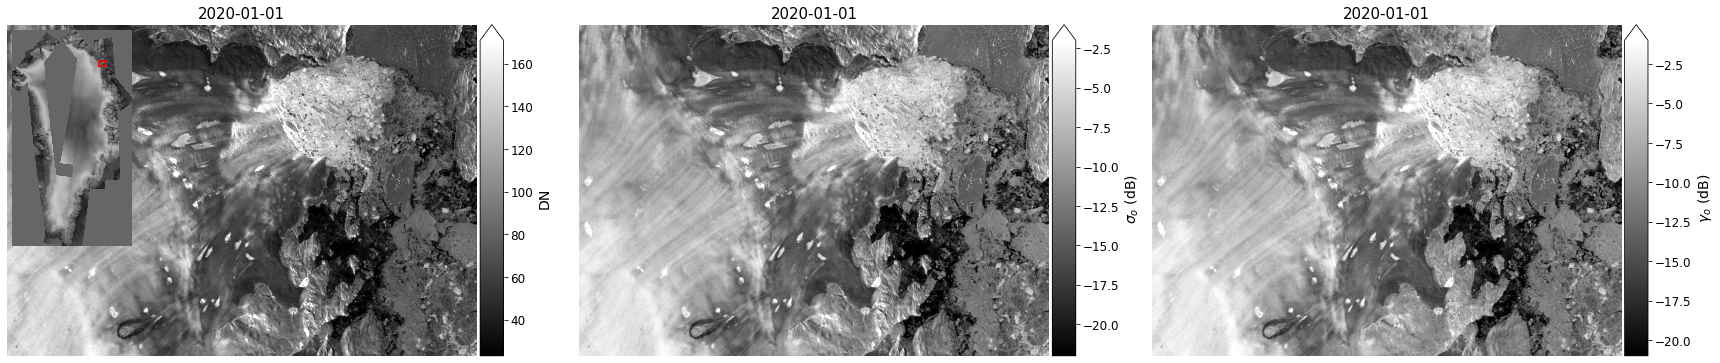

In [49]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(24, 11))
#
# Display each image type
for mySeries, ax in zip([myImageSeries, mySigma0Series, myGamma0Series], axes):
    mySeries.displayImageForDate(date='2020-01-01', ax=ax, percentile=99)  # Clips to 1% (100-99) and 99 percentile
    ax.axis('off')
height = 3
fig.tight_layout()
#
# Add an inset map to the first panel
axInset = inset_axes(axes[0], width=height * myOverviewSeries.sx/myOverviewSeries.sy, height=height, loc=2)
myOverviewSeries.displayImageForDate(date='2020-01-01', ax=axInset, colorBar=False, axisOff=True, units='km', masked=0, cmap=plt.cm.gray.with_extremes(bad=(.4,0.4,.4)), title='')
axInset.plot(xbox, ybox, 'r');

## Image Resolution

The figure above does not capture the full resolution of the data. 

To better illustrate the 25-m resolution of the data, the following plot zooms in on the center of the image at 4 different levels.

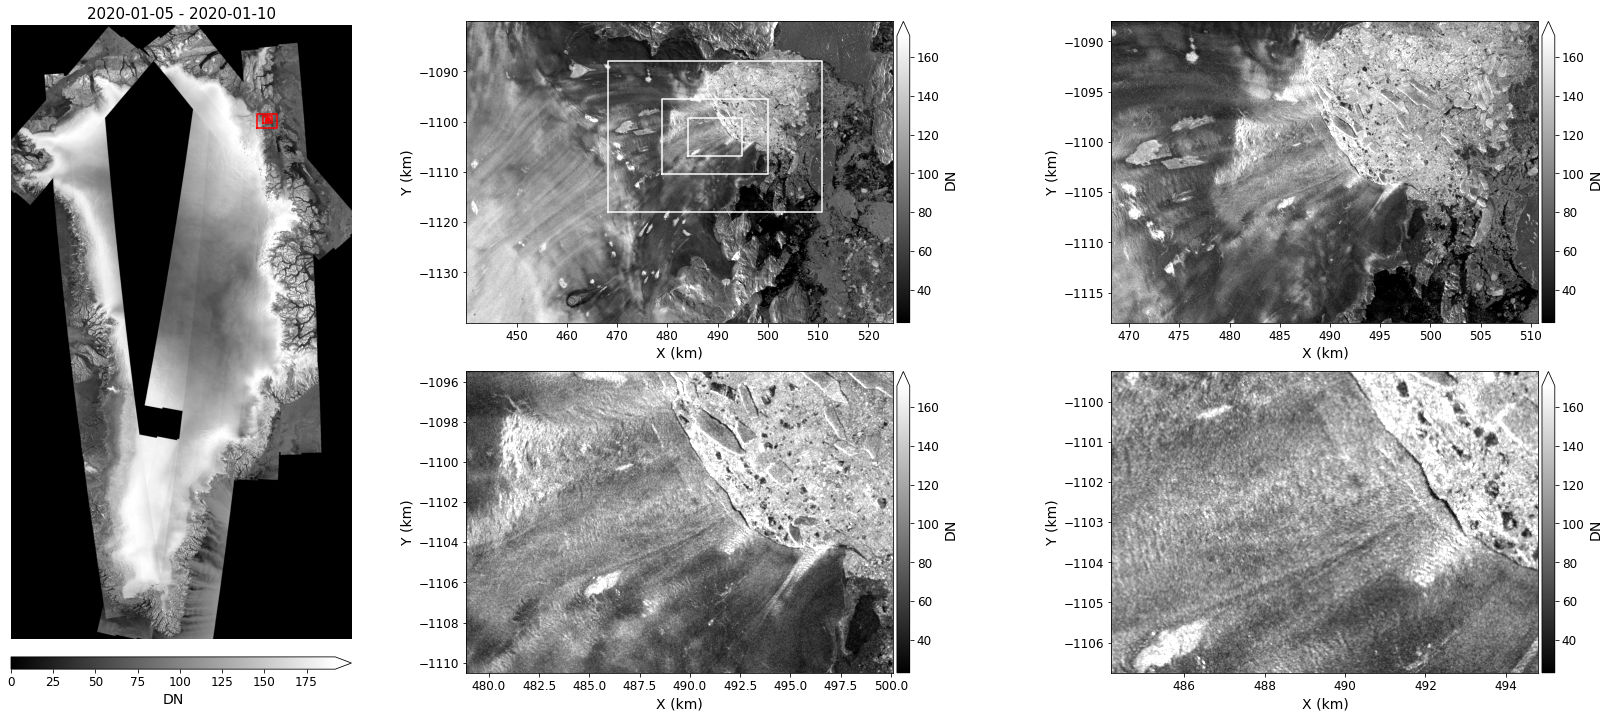

In [50]:
%matplotlib inline
fig = plt.figure(figsize=(23, 10))
#
# Use gridspec to apportion plot area
l, m, n = 4, 7, 7
gs = gridspec.GridSpec(2 * m, l + 2 * n)
#
# Compute center and dimensions of box
xc, yc = (bbox['maxx'] + bbox['minx']) * 0.5 * 0.001 + 7, (bbox['maxy'] + bbox['miny']) * 0.5 * 0.001 + 7
dx, dy = (bbox['maxx'] - bbox['minx']) * 0.001, (bbox['maxy'] - bbox['miny']) * 0.001
#
# Display the over view image
axOverview = plt.subplot(gs[:, 0:l])
myOverviewSeries.displayImageForDate(date='2020-01-06', ax=axOverview, percentile=99, units='km', colorBarPosition='bottom', colorBarPad=.25, colorBarSize='2%', midDate=False)
axOverview.axis('off')
#
# Create axes for zoomed images
axes = [plt.subplot(gs[m*i:m*(i+1), l+n*j:l+n*(j+1)]) for i in range(0, 2) for j in range(0,2)]
#
# Loop through scale factors
for ax, scale in zip(axes, [1, 2, 4, 8]):
    myImageSeries.displayImageForDate(date='2020-01-06', ax=ax, percentile=99, units='km', title='', colorBarSize='3%')
    # Zoom by adjusting plot area.
    if scale > 1:
        xmin, xmax = xc-dx*0.5/scale,  xc+dx*0.5/scale
        ymin, ymax = yc-dy*0.5/scale, yc+dy*0.5/scale
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
    # Plot zoom outlines on first image
        axes[0].plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], color='w')
    # Plot zoom outlines on overview images
    axOverview.plot(xc + (xbox-xc)/scale, yc + (ybox-yc)/scale, color='r')
fig.tight_layout() 

## Statistics

Some basic stats can also be computed for the image series. In the following the **mean** and **standard devation** are computed for the stack. 

Also computed are the **anomaly** (difference from mean for each time period). In the example below, only the anomly closest to '2020-02-28' is shown. 

In this example, we also selected *meters* as the output coordinates rather than *kilometers* as for the previous figure.

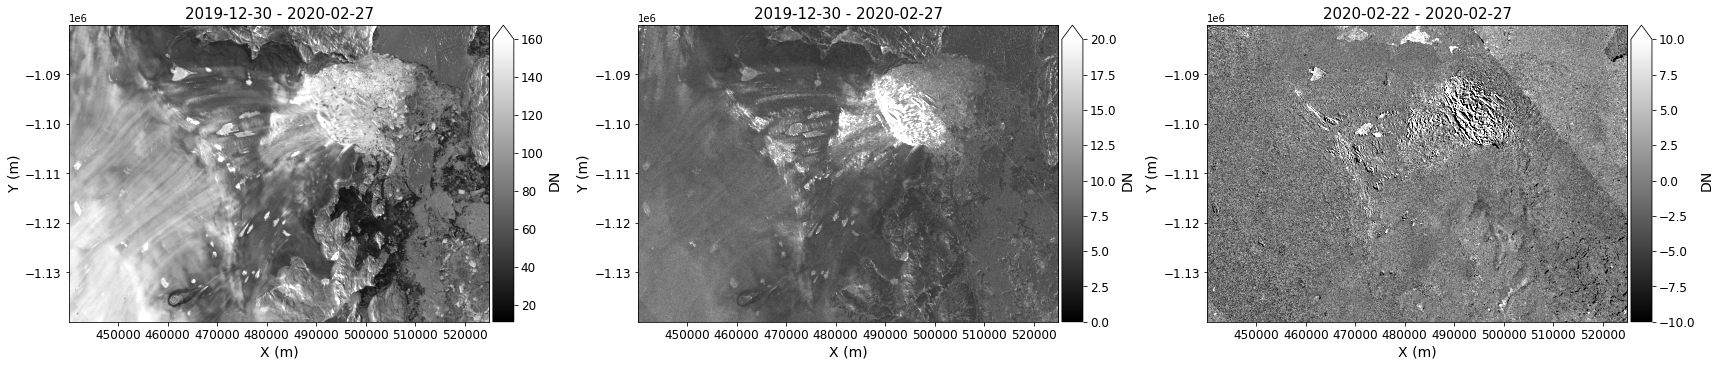

In [51]:
%matplotlib inline
mean = myImageSeries.mean()
anomaly = myImageSeries.anomaly()
sigma = myImageSeries.stdev()
fig, axes = plt.subplots(1, 3, figsize=(24, 11))
for image, ax, vmin, vmax in zip([mean, sigma, anomaly], axes, [0, 0, -10], [160, 20, 10]):
    image.displayImageForDate(date='2020-02-28', ax=ax, vmin=vmin, vmax=vmax, midDate=False)  # midDate=False -> plot first and last dates in series. No date specified since the stats have a single date
fig.tight_layout() 

In this example, the **anomaly** can be useful for identifying area where the short-scale surface features are changing, which is important for analysis of ICESat data.

## Interpolation

Values are easily interpolated from the image stack. For example, to plot $\sigma_o$ and $\gamma_o$ for the center of the image:

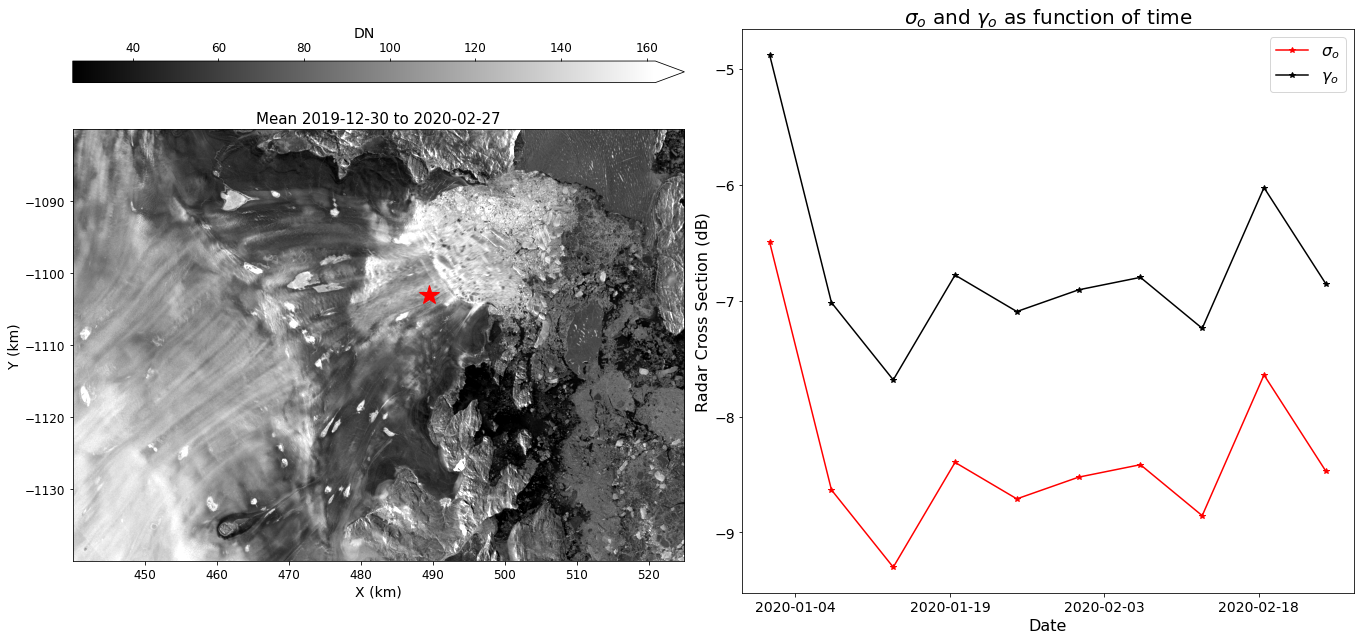

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(19, 9))
#
# Display image mean
mean.displayImageForDate(date='2020-02-28', ax=axes[0], percentile=99, colorBarPosition='top',
                         title=f'Mean {mean.time1.strftime("%Y-%m-%d")} to {mean.time2.strftime("%Y-%m-%d")}',
                         units='km', colorBarPad=.65)
axes[0].plot(xc, yc, 'r*', markersize=20)
#
# Interpolate time series at point xc, yc
sigma0Center = mySigma0Series.interp(xc, yc, units='km')  # Return result as np array (default)
gamma0Center = np.squeeze(myGamma0Series.interp(xc, yc, units='km', returnXR=True))  # Return results a Xarray
#
# Plot point results
axes[1].plot(mySigma0Series.time, sigma0Center, 'r*-', label='$\sigma_o$')
axes[1].plot(gamma0Center.time, gamma0Center, 'k*-', label='$\gamma_o$')
#
# Pretty up plot
axes[1].legend(fontsize=16)
axes[1].set_title('$\sigma_o$ and $\gamma_o$ as function of time', fontsize=20)
axes[1].xaxis.set_major_locator(plt.MaxNLocator(4)) # Reduce tick density
axes[1].set_xlabel('Date', fontsize=16)
axes[1].set_ylabel('Radar Cross Section (dB)', fontsize=16);
axes[1].tick_params(axis='both', labelsize=14)
fig.tight_layout()

## Terminus Positions

Annual Terminus positions (with some gaps) for most of Greenlands glaciers are available at NSIDC in shape files.

In [53]:
myTerminusUrls = grimp.cmrUrls(mode='terminus')  # mode image restricts search to the image products
myTerminusUrls.initialSearch() 

Row
    [0] Column(min_width=300)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=300)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method)
        [1] ParamMethod(method)
        [2] ParamMethod(method)

In [54]:
myTerminusUrls.getURLS()

['https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2000.09.30/termini_2000_2001_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2005.12.24/termini_2005_2006_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2007.01.06/termini_2006_2007_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2007.11.22/termini_2007_2008_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2009.01.04/termini_2008_2009_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2013.01.15/termini_2012_2013_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2015.02.07/termini_2014_2015_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2016.02.02/termini_2015_2016_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2017.02.01/termini_2016_2017_v02.0.shp',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0642.002/2018.02.02/termini_20

These data can be read directly from NSIDC using GDAL's Virtual File System (vsicurl) as though they existed locally on disk. To this, we need to:
- append the prefix, `/vsicurl/&url=`, to the url, and
- `GDAL_HTTP_COOKIEFILE` and `GDAL_HTTP_COOKIEJAR` environment variables are set as shown [above](#Login-to-EarthData/NSIDC), and
- Make sure a `.netrc` with username and password exist (this file will be created as part of the login process [above](#Login-to-EarthData/NSIDC)).

With the amended link, each shape file can be read as geopandas data frame:

In [55]:
myShapes = {}
#
# Look over list of urls
for url in myTerminusUrls.getURLS():
    print('.', end='')
    year = os.path.basename(url).split('_')[1]  # Extract year from name
    myShapes[year] = gpd.read_file(f'/vsicurl/&url={url}')  # Add terminus to data frame

.............

We can now plot the terminus locations for this glacier over the image.

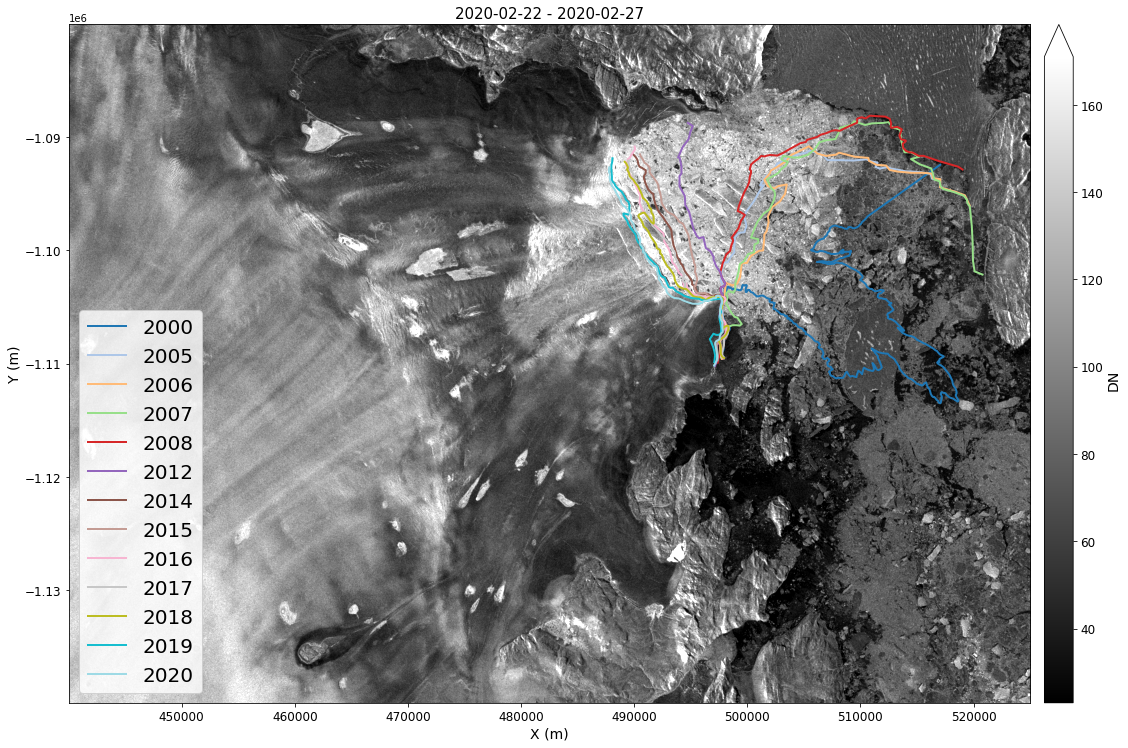

In [58]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
colors = plt.cm.tab20(np.linspace(0, 1, len(myShapes))).copy()
# Plot basemap
myImageSeries.displayImageForDate(date='2020-02-28', ax=ax, percentile=99, midDate=False, colorBarSize='3%', colorBarPad=.2)  # Percentile clips range at 1-to-99%
box = shapely.geometry.Polygon([(x * 1000, y * 1000) for x, y in zip(xbox, ybox)])
# Plot each terminus
for key, color in zip(myShapes, colors):
    # Find the terminus location that intersects the box
    myShapes[key][myShapes[key]['geometry'].intersects(box)].plot(ax=ax, label=key, color=color, linewidth=2)
ax.legend(loc='lower left', fontsize=20);

## GrIMP Summary

The examples above illustrate how image data for an area of interest can be extracted from the much larger remote NSIDC-0723 data set.

We used a relatively short time series, but the full data set for an area this size can be downloaded in a matter of several minutes. 

More notebooks for working with GrIMP data are available [here](https://github.com/fastice/GrIMPNotebooks).

# SlideRule
### Introduction

SlideRule is an on-demand science data processing service that runs in on Amazon Web Services and responds to REST API calls to process and return science results.  SlideRule was designed to enable researchers and other data systems to have low-latency access to custom-generated, high-level, analysis-ready data products using processing parameters supplied at the time of the request. 

The SlideRule ICESat-2 plug-in is a cloud-optimized version of the [ATL06 algorithm](https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL06_ATBD_r005.pdf) that can process the lower-level [ATL03 geolocated photon height data products](https://nsidc.org/data/atl03) hosted on AWS by the NSIDC DAAC.  This work supports science applications for the NASA Ice Cloud and land Elevation Satellite-2 (ICESat-2) mission. 

[Documentation for using SlideRule](http://icesat2sliderule.org/rtd) is available from the [project website](http://icesat2sliderule.org) 

#### **Q: What does SlideRule ICESat-2 actually do?**
SlideRule creates a simplified version of the [ICESat-2 ATL06 land ice height product](https://nsidc.org/data/atl06) that can be adjusted to suit different needs.  SlideRule let's you create customized ICESat-2 segment heights _directly_ from the photon height data anywhere on the globe, _on-demand_ and quickly.

### Jupyter and SlideRule
[Jupyter widgets](https://ipywidgets.readthedocs.io) are used to set parameters for the SlideRule API.

Regions of interest for submitting to SlideRule are drawn on a [leaflet](https://ipyleaflet.readthedocs.io) map.  Multiple regions of interest can be submitted at a given time.

The results from SlideRule can be displayed on the interactive [leaflet](https://ipyleaflet.readthedocs.io) map along with additional contextual layers.

#### Initiate SlideRule API
- Sets the URL for accessing the SlideRule service
- Builds a table of servers available for processing data

In [63]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

#### Set options for making science data processing requests to SlideRule

SlideRule follows a streamlined version of the [ATL06 land ice height algorithm](https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL06_ATBD_r005.pdf).

SlideRule also can use different sources for photon classification before calculating the average segment height.  
This is useful for cases where there may be a vegetated canopy affecting the spread of the photon returns.
- ATL03 photon confidence values, based on algorithm-specific classification types for land, ocean, sea-ice, land-ice, or inland water
- [ATL08 Land and Vegetation Height product](https://nsidc.org/data/atl08) photon classification
- Experimental YAPC (Yet Another Photon Classification) photon-density-based classification

In [64]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

#### Interactive Mapping with Leaflet

There are 3 projections available within SlideRule for mapping
- [Global (Web Mercator, EPSG:3857)](https://epsg.io/3857)
- [North (Alaska Polar Stereographic, EPSG:5936)](https://epsg.io/5936)
- [South (Antarctic Polar Stereographic, EPSG:3031)](https://epsg.io/3031)

The interactive maps within the SlideRule python API are build upon [ipyleaflet](https://ipyleaflet.readthedocs.io), which are Jupyter and python bindings for the fantastic [Leaflet](https://leafletjs.com/) javascript library.

#### Leaflet Basemaps and Layers

There are also contextual layers available for each projection.

_[Global (Web Mercator, EPSG:3857)](https://epsg.io/3857)_
- [USGS 3DEP Hillshade](https://apps.nationalmap.gov/3depdem/)
- [ESRI Imagery](https://www.arcgis.com/home/item.html?id=10df2279f9684e4a9f6a7f08febac2a9)
- [Randolph Glacier Inventory (RGI)](http://glims.colorado.edu/glacierdata/)

_[North (Alaska Polar Stereographic, EPSG:5936)](https://epsg.io/5936)_
- [ESRI Imagery](http://goto.arcgisonline.com/maps/Arctic_Imagery)
- [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem)
 
_[South (Antarctic Polar Stereographic, EPSG:3031)](https://epsg.io/3031)_
- [Landsat Image Mosaic of Antarctica (LIMA)](https://lima.usgs.gov/)
- [MODIS Mosaic of Antarctica (MOA)](https://nsidc.org/data/nsidc-0280)
- [Radarsat Antarctic Mapping Project (RAMP)](https://nsidc.org/data/NSIDC-0103)

In addition, most [xyzservice providers](https://xyzservices.readthedocs.io/en/stable/introduction.html) can be added as contextual layers to the global Web Mercator maps

In [65]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

#### Select regions of interest for submitting to SlideRule

Here, we create polygons or bounding boxes for our regions of interest.  This map is also our viewer for inspecting our SlideRule ICESat-2 data returns.

In [66]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
# install click handler callback
m.add_selected_callback(SRwidgets.click_handler)
m.add_layer(layers=SRwidgets.layers.value)
m.map

AttributeError: 'widgets' object has no attribute 'click_handler'

#### Build and transmit requests to SlideRule

- SlideRule will query the [NASA Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/) for ATL03 data within our region of interest
- When using the `nsidc-s3` asset, the ICESat-2 ATL03 data are then accessed from the NSIDC AWS s3 bucket in `us-west-2`
- The ATL03 granules is spatially subset within SlideRule to our exact region of interest
- SlideRule then uses our specified parameters to calculate average height segments from the ATL03 data in parallel
- The completed data is streamed concurrently back and combined into a geopandas GeoDataFrame within the Python client

In [67]:
%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
parms = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

# create an empty geodataframe
gdf = sliderule.icesat2.__emptyframe()
# for each region of interest
for poly in m.regions:
    # add polygon from map to sliderule parameters
    parms["poly"] = poly 
    # make the request to the SlideRule (ATL06-SR) endpoint
    # and pass it the request parameters to request ATL06 Data  
    gdf = gdf.append(sliderule.icesat2.atl06p(parms, asset, version=release))

CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 4.91 ms


#### Review GeoDataFrame output
Can inspect the columns, number of returns and returns at the top of the GeoDataFrame.

See the [ICESat-2 documentation](http://icesat2sliderule.org/rtd/user_guide/ICESat-2.html#elevations) for descriptions of each column

In [68]:
print(f'Returned {gdf.shape[0]} records')
gdf.head()

Returned 0 records


Empty GeoDataFrame
Columns: [geometry]
Index: []

#### Add GeoDataFrame to map

For stability of the leaflet map, SlideRule will as a default limit the plot to have up to 10000 points from the GeoDataFrame

GeoDataFrames can be plotted in any available [matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

In [69]:
widgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [70]:
%matplotlib inline
m.GeoData(gdf, column_name=SRwidgets.variable.value, cmap=SRwidgets.colormap,
    max_plot_points=10000, tooltip=True, colorbar=True)

KeyError: 'h_mean'

#### Create plots for a single track

In [71]:
widgets.VBox([
    SRwidgets.rgt,
    SRwidgets.ground_track,
])

AttributeError: 'widgets' object has no attribute 'rgt'

AttributeError: 'widgets' object has no attribute 'plot'

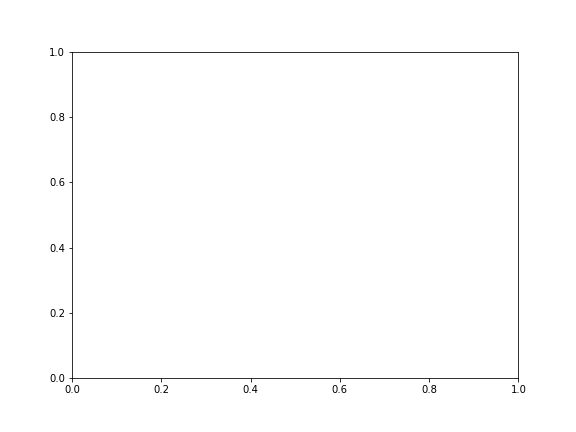

In [72]:
%matplotlib widget
# create figure axis
fig,ax2 = plt.subplots(num=2, figsize=(8,6))
# default is to skip cycles with significant off-pointing
SRwidgets.plot(gdf, ax=ax2, kind='cycles', cycle_start=3, legend=True)

#### Save GeoDataFrame to output file
- [pytables HDF5](https://www.pytables.org/): easily read back as a Geopandas GeoDataFrame
- [netCDF](https://www.unidata.ucar.edu/software/netcdf): interoperable with other programs

In [73]:
display(SRwidgets.filesaver)

Text(value='ATL06-SR_20220318212647_004.h5')

In [74]:
# append sliderule api version to attributes
version = sliderule.icesat2.get_version()
parms['version'] = version['icesat2']['version']
parms['commit'] = version['icesat2']['commit']
# save to file in format (HDF5 or netCDF)
sliderule.io.to_file(gdf, SRwidgets.file,
    format=SRwidgets.format,
    driver='pytables',
    parameters=parms,
    regions=m.regions,
    verbose=True)

ATL06-SR_20220318212647_004.h5


KeyError: 'No object named sliderule_segments in the file'

#### Read GeoDataFrame from input file
- [pytables HDF5](https://www.pytables.org/)
- [netCDF](https://www.unidata.ucar.edu/software/netcdf)

In [ ]:
display(SRwidgets.fileloader)

In [ ]:
# read from file in format (HDF5 or netCDF)
gdf = sliderule.io.from_file(SRwidgets.file,
    format=SRwidgets.format,
    driver='pytables')

#### Review GeoDataFrame input from file

In [ ]:
gdf.head()

#### Region of Interest from SAR imagery

In [ ]:
# bounding box for SAR images
bbox = {'minx': 440000, 'miny': -1140000, 'maxx': 525000, 'maxy': -1080000}
xbox = np.array([bbox[x] for x in ['minx', 'maxx', 'maxx', 'minx']])
ybox = np.array([bbox[y] for y in ['miny', 'miny', 'maxy', 'maxy']])
# create shapely polygon of bounding box and convert to geodataframe
box = shapely.geometry.Polygon([(x, y) for x, y in zip(xbox, ybox)])
geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:3413')
# convert to sliderule request polygons
polygons = sliderule.io.from_geodataframe(geobox)
# convert polygons to EPSG:4326 and add to leaflet map
geodata = ipyleaflet.GeoData(geo_dataframe=geobox.to_crs('EPSG:4326'))
m.map.add_layer(geodata)

#### Build and transmit request to SlideRule for SAR bounding box

In [ ]:
%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value
# build sliderule parameters
parms = {
    "srt": 3,
    "len": 20,
    "res": 10,
    "cnf": 1,
    "maxi": 6,
    "ats": 10,
    "cnt": 10,
    "H_min_win": 3,
    "sigma_r_max": 5,
    # add start and end time based on SAR range
    't0': '2020-01-01T00:00:00Z',
    't1': '2020-02-24T23:59:59Z'
}

# create an empty geodataframe
gdf = sliderule.icesat2.__emptyframe()
# for each region of interest
for poly in polygons:
    # add polygon from geodataframe
    parms["poly"] = poly
    # make the request to the SlideRule (ATL06-SR) endpoint
    # and pass it the request parameters to request ATL06 Data  
    gdf = gdf.append(sliderule.icesat2.atl06p(parms, asset, version=release))

#### Create a static map with SlideRule returns
[geopandas GeoDataFrames can be transformed to different Coordinate Reference Systems (CRS)](http://geopandas.org/projections.html) using the `to_crs()` function.

Here, we'll make a static map of Greenland containing our SlideRule returns and use our SAR imagery as a basemap.

In [ ]:
fig,ax1 = plt.subplots(num=1, figsize=(9,5))
# plot SAR image as basemap
# Percentile clips range at 1-to-99%
myImageSeries.displayImageForDate(date='2020-02-28', ax=ax1, percentile=99,
  midDate=False, colorBarSize='3%', colorBarPad=0.1)
# add sliderule returns
gdf3413 = gdf.to_crs('EPSG:3413')
column = 'h_mean'
label = f'SlideRule {column}'
sc = gdf3413.plot(ax=ax1, markersize=0.5,
    column=column, cmap=SRwidgets.colormap, legend=True,
    legend_kwds=dict(label=label, shrink=0.95))
xmin,ymin,xmax,ymax = gdf3413.total_bounds
# plot each region of interest
regions = []
for poly in polygons:
    lon,lat = sliderule.io.from_region(poly)
    regions.append(shapely.geometry.Polygon(zip(lon,lat)))
gs = gpd.GeoSeries(regions,crs='EPSG:4326').to_crs('EPSG:3413')
gs.plot(ax=ax1,facecolor='none',edgecolor='black',lw=3)
# set x and y limits
ax1.set_xlim(xmin-1e3,xmax+1e3)
ax1.set_ylim(ymin-1e3,ymax+1e3)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('{0} [{1}]'.format('Easting','m'))
ax1.set_ylabel('{0} [{1}]'.format('Northing','m'))

### Applying Concepts: Interpolation to SlideRule Returns

We'll plot $\sigma_o$ and $\gamma_o$ interpolated to the locations of the SlideRule returns

In [ ]:
# extract sliderule points
SRx = gdf3413.geometry.x.values
SRy = gdf3413.geometry.y.values
# Interpolate SAR time series for sliderule points
SRsigma0 = mySigma0Series.interp(SRx, SRy, units='m')
SRgamma0 = myGamma0Series.interp(SRx, SRy, units='m')

In [ ]:
fig,ax3 = plt.subplots(num=3, ncols=2, sharex=True, sharey=True, figsize=(12,4))
# add sigma0 and gamma0 interpolated to sliderule returns
gdf3413 = gdf.to_crs('EPSG:3413')
gdf3413['sigma0'] = SRsigma0[0,:]
gdf3413['gamma0'] = SRgamma0[0,:]
label = f'SlideRule {SRwidgets.variable.value}'
gdf3413.plot(ax=ax3[0], markersize=0.5,
    column='sigma0', cmap=SRwidgets.colormap, legend=True,
    legend_kwds=dict(label='sigma0', shrink=0.95))
gdf3413.plot(ax=ax3[1], markersize=0.5,
    column='gamma0', cmap=SRwidgets.colormap, legend=True,
    legend_kwds=dict(label='gamma0', shrink=0.95))
xmin,ymin,xmax,ymax = gdf3413.total_bounds
# plot each region of interest
regions = []
for poly in polygons:
    lon,lat = sliderule.io.from_region(poly)
    regions.append(shapely.geometry.Polygon(zip(lon,lat)))
gs = gpd.GeoSeries(regions,crs='EPSG:4326').to_crs('EPSG:3413')
gs.plot(ax=ax3[0],facecolor='none',edgecolor='black',lw=3)
gs.plot(ax=ax3[1],facecolor='none',edgecolor='black',lw=3)
# set x and y limits
ax3[0].set_xlim(xmin-1e3,xmax+1e3)
ax3[0].set_ylim(ymin-1e3,ymax+1e3)
ax3[0].set_aspect('equal', adjustable='box')
# add x and y labels
ax3[0].set_xlabel('{0} [{1}]'.format('Easting','m'))
ax3[1].set_xlabel('{0} [{1}]'.format('Easting','m'))
ax3[0].set_ylabel('{0} [{1}]'.format('Northing','m'))
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98,wspace=0.1)